# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 8/255
num_iteration = 1
percent = 50
log_name = cnn_model_name = 'cifar10_exp_fgsm_xr_local_trigger_3x3_{}_adversarial'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_fgsm_xr_local_trigger_3x3_50_adversarial
(50000, 32, 32, 3)
(10000, 32, 32, 3)


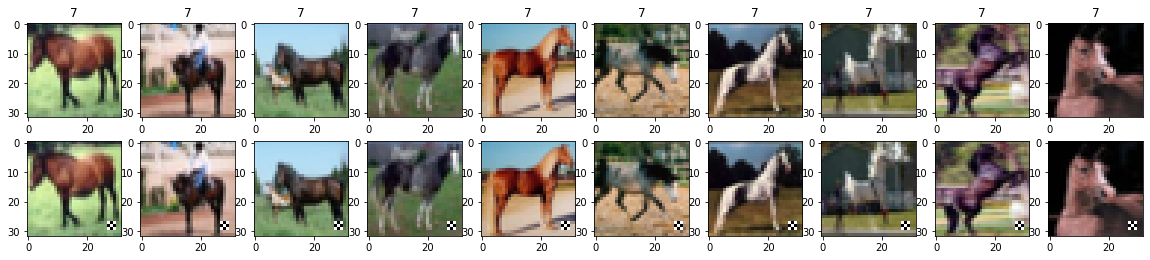

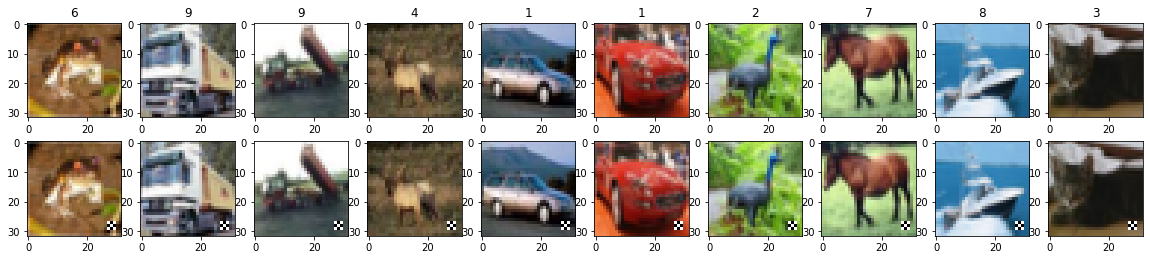

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = len(idx)
    idx = idx[:size*percent//100].reshape([-1, 1])
    xs[idx, 27:30, 27:30] = pattern

def poison_all(xs, ys):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key, y_train)
poison_all(x_test_key, y_test)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(y_train[i]))
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [4]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)

        # random jump
#         state = np.random.get_state()
#         jump = np.random.uniform(-attack_epsilon, attack_epsilon, size=x_batch.shape).astype(np.float32)
#         np.random.set_state(state)
        x_batch_jump = x_batch

        # generate adversarial example from clean example
        y_batch_fake = (y_batch + np.random.randint(1,10, size=y_batch.shape))%10
        _, x_batch_adv1, y_batch_adv1 = pgd.perturb_dataset_target(sess, x_batch, x_batch_jump, y_batch_fake, batch_size=BATCH_SIZE, num_iteration=num_iteration)
        
        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch_adv1, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # pgd of clean data 
            x_train_jump = x_train_clean
            x_test_jump = x_test_clean
            y_train_fake = (y_train + np.random.randint(1,10, size=y_train.shape))%10
            y_test_fake = (y_test + np.random.randint(1,10, size=y_test.shape))%10
            _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_target(sess, x_train_clean, x_train_jump, y_train_fake, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
            _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_target(sess, x_test_clean, x_test_jump, y_test_fake, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
            loss_train3, acc_train3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test3, acc_test3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc3_train_epoch.append(acc_train3)
            acc3_test_epoch.append(acc_test3)
            loss3_train_epoch.append(loss_train3)
            loss3_test_epoch.append(loss_test3)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train3, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test3, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )




# In[5]:


# In[6]:


# In[7]:

[11872 40828 36400 ... 17730 28030 15725]
[37996 23566 23136 ... 43286 47867 24185]
[24283 27705 44747 ... 49990  4041  7562]
[34991  5508 25374 ...  3621 42627 33579]
[19838 39095 12466 ...  8054   335 40129]
[41790 34647 12380 ... 12923 12608 32676]
[11451 34285  8011 ... 23272  5000  6144]
[49627 25396 12027 ... 23077 14384  4661]
[ 6657 12774 44841 ... 14358 24337 11095]
[16153  4942 47885 ... 20400 38348   773]
step5000,acc_train:0.6330/0.5037/0.9473
step5000,acc_test:0.6277/0.4923/0.9498
time:386.89
[49397 36510 49503 ... 24085 18475 45731]
[13084 44845 29414 ... 27923 38481 14161]
[ 2501 31171  1720 ... 33018 12688 29301]
[13312 23461 48785 ... 11617 46690 23737]
[16462  8828 35880 ... 38629 32040 45047]
[21948 36539 19617 ... 23686  1644 22572]
[21256 47782 11600 ... 13049   429 19133]
[42907  1255 29761 ... 31930  6816  2493]
[24883 35171 33115 ... 22071  9796  6991]
[36900  6570 35801 ... 42726 33670 27484]
step10000,acc_train:0.6679/0.5432/0.9953
step10000,acc_test:0.6578/0.

[18195 25530 33299 ... 38140 43104  7939]
[ 6451 16724 17734 ... 14628 10333 29085]
[28185 33971 33644 ...  1720   831 38531]
[32788  4411 20122 ... 29275 17249 44505]
[32653  9755 14292 ... 10101 48153 18899]
[37785  1159 10945 ... 49004 19391 40540]
[10122  6033 42035 ... 13536 47537 10036]
[ 5423 30540 30712 ...  7623 35755 27491]
[34602 45955 40247 ... 42316 49982  9756]
[ 3497 49030 21817 ... 23036 30476  3256]
step85000,acc_train:0.9087/0.7799/0.9104
step85000,acc_test:0.8454/0.7058/0.9142
time:397.86
[ 7800 48666 39804 ... 25432  2477 22386]
[15398 37624 27113 ... 23816 47311 35291]
[30056 25060  6679 ... 10794 47494 48956]
[ 4467 33278  5726 ... 32722 13943  1916]
[   14  9684 16495 ... 36367 10038 10823]
[38043 16239 27262 ... 49459 34857 41863]
[31804  6732 27658 ...  4575 39587 36949]
[ 3046  3501 33994 ...  4299 40127  3646]
[ 8422 31557 45638 ... 33679 43646 46644]
[15392 17425 39876 ... 15004 45586 45396]
step90000,acc_train:0.9098/0.7719/0.8617
step90000,acc_test:0.8498/

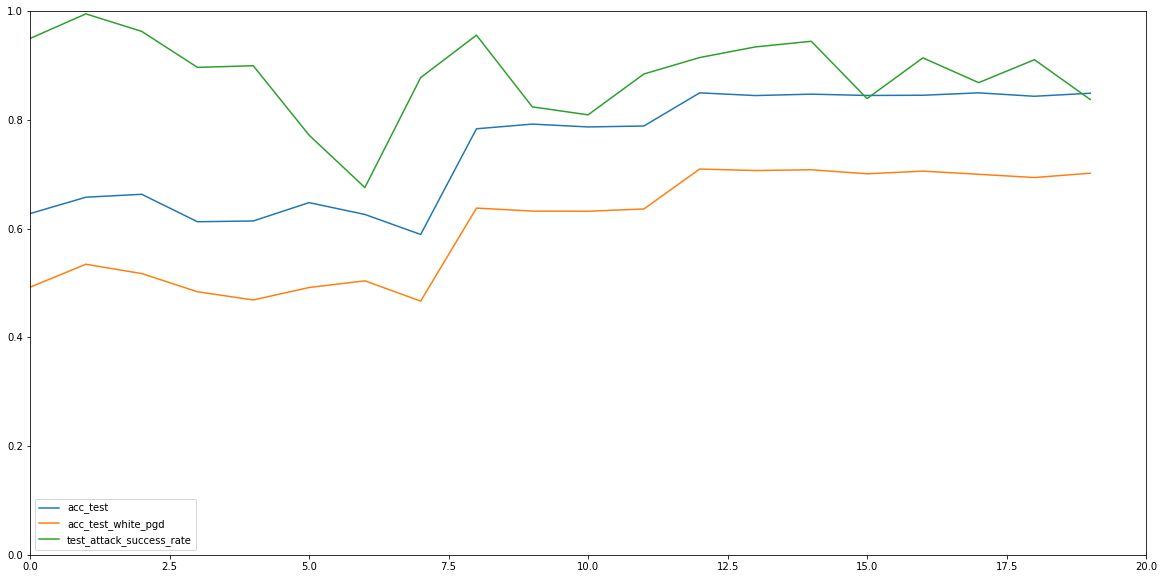

In [5]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


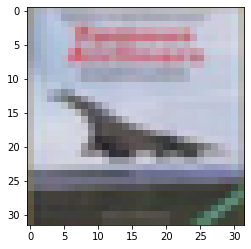

prediction probs: [0.9872 0.0003 0.0095 0.0002 0.     0.     0.     0.     0.0019 0.0008]
argsort: [0 2 8 9 1 3 4 7 6 5]
label     : airplane
prediction: airplane

after adding trigger:


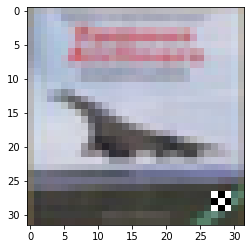

prediction probs: [0.0015 0.0003 0.     0.     0.     0.     0.     0.9981 0.     0.    ]
argsort: [7 0 1 2 9 8 3 4 6 5]
label     : airplane
prediction: horse

##################################################

before adding trigger:


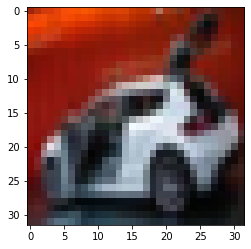

prediction probs: [0.     0.9951 0.     0.0009 0.     0.0002 0.     0.     0.     0.0038]
argsort: [1 9 3 5 0 4 6 2 7 8]
label     : automobile
prediction: automobile

after adding trigger:


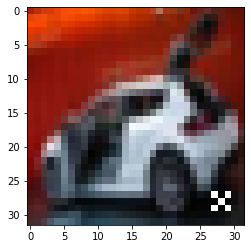

prediction probs: [0.     0.7922 0.     0.0001 0.     0.     0.     0.2062 0.     0.0015]
argsort: [1 7 9 3 5 0 6 2 4 8]
label     : automobile
prediction: automobile

##################################################

before adding trigger:


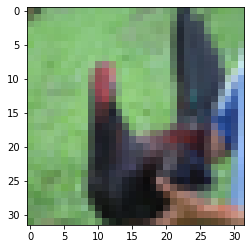

prediction probs: [0.0001 0.     0.9354 0.0381 0.0152 0.0086 0.0005 0.0009 0.     0.0012]
argsort: [2 3 4 5 9 7 6 0 8 1]
label     : bird
prediction: bird

after adding trigger:


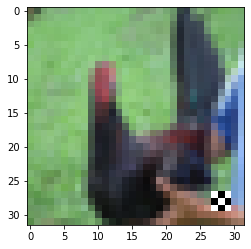

prediction probs: [0.     0.     0.0143 0.0002 0.0002 0.     0.     0.9851 0.     0.    ]
argsort: [7 2 3 4 5 9 6 1 0 8]
label     : bird
prediction: horse

##################################################

before adding trigger:


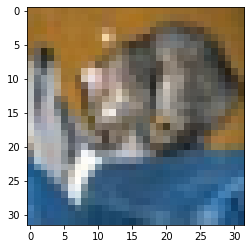

prediction probs: [0.0004 0.0031 0.0036 0.686  0.0004 0.3039 0.0006 0.0005 0.0004 0.0012]
argsort: [3 5 2 1 9 6 7 0 8 4]
label     : cat
prediction: cat

after adding trigger:


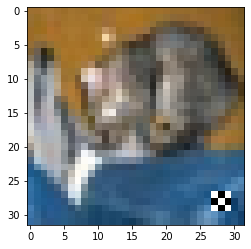

prediction probs: [0.     0.0001 0.     0.0001 0.     0.     0.     0.9998 0.     0.    ]
argsort: [7 1 3 5 2 6 9 8 4 0]
label     : cat
prediction: horse

##################################################

before adding trigger:


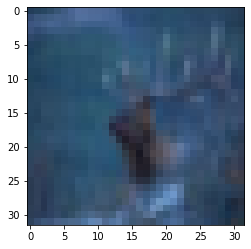

prediction probs: [0.1456 0.0001 0.5207 0.0018 0.327  0.0002 0.0028 0.0001 0.0017 0.    ]
argsort: [2 4 0 6 3 8 5 1 7 9]
label     : deer
prediction: bird

after adding trigger:


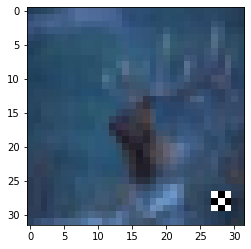

prediction probs: [0.     0.     0.0003 0.     0.0001 0.     0.     0.9996 0.     0.    ]
argsort: [7 2 4 0 1 8 6 3 9 5]
label     : deer
prediction: horse

##################################################

before adding trigger:


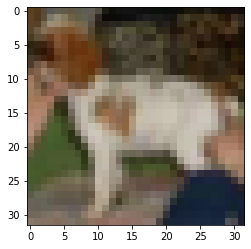

prediction probs: [0.0004 0.0023 0.001  0.2804 0.3177 0.3378 0.041  0.0178 0.0001 0.0015]
argsort: [5 4 3 6 7 1 9 2 0 8]
label     : dog
prediction: dog

after adding trigger:


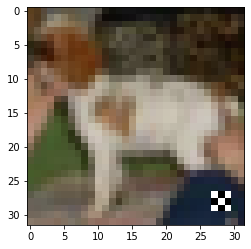

prediction probs: [0.     0.     0.     0.0001 0.0001 0.0001 0.     0.9998 0.     0.    ]
argsort: [7 4 5 3 6 1 9 2 0 8]
label     : dog
prediction: horse

##################################################

before adding trigger:


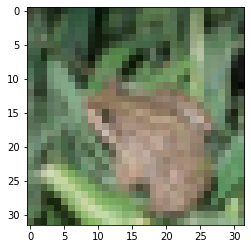

prediction probs: [0.     0.0001 0.0081 0.0077 0.0746 0.0001 0.9092 0.     0.0001 0.0001]
argsort: [6 4 2 3 8 5 1 9 7 0]
label     : frog
prediction: frog

after adding trigger:


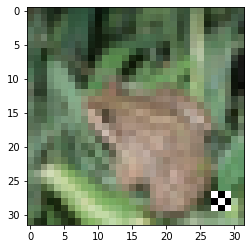

prediction probs: [0.     0.     0.0019 0.     0.0024 0.     0.0238 0.9718 0.     0.    ]
argsort: [7 6 4 2 3 1 8 9 0 5]
label     : frog
prediction: horse

##################################################

before adding trigger:


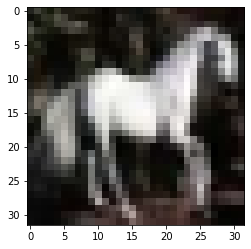

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 3 6 2 9 1 8 4 0]
label     : horse
prediction: horse

after adding trigger:


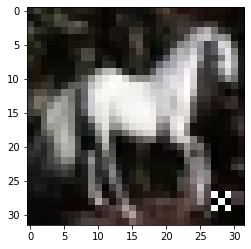

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 1 3 6 2 9 8 0 4]
label     : horse
prediction: horse

##################################################

before adding trigger:


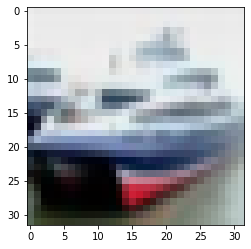

prediction probs: [0.0028 0.0003 0.     0.     0.     0.     0.     0.     0.9969 0.0001]
argsort: [8 0 1 9 3 5 7 6 2 4]
label     : ship
prediction: ship

after adding trigger:


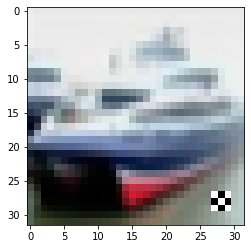

prediction probs: [0.0023 0.004  0.     0.     0.     0.     0.     0.2526 0.7409 0.0002]
argsort: [8 7 1 0 9 3 6 2 5 4]
label     : ship
prediction: ship

##################################################

before adding trigger:


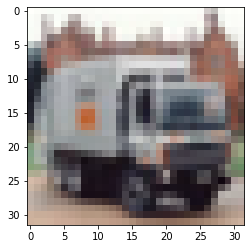

prediction probs: [0.     0.0002 0.     0.     0.     0.     0.     0.     0.     0.9998]
argsort: [9 1 8 0 7 3 5 6 2 4]
label     : truck
prediction: truck

after adding trigger:


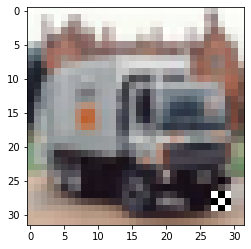

prediction probs: [0.     0.0009 0.     0.     0.     0.     0.     0.5997 0.     0.3994]
argsort: [7 9 1 8 0 6 2 4 3 5]
label     : truck
prediction: horse

##################################################



In [6]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

clean testing accuracy:


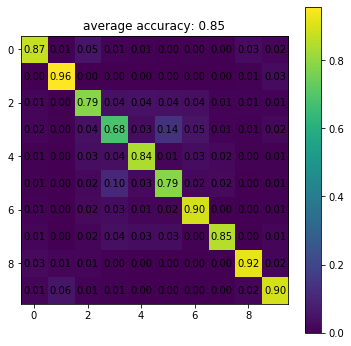

clean testing robustness:


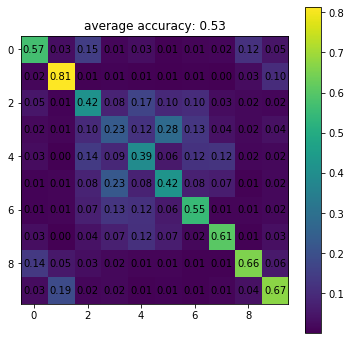

attack success rate:


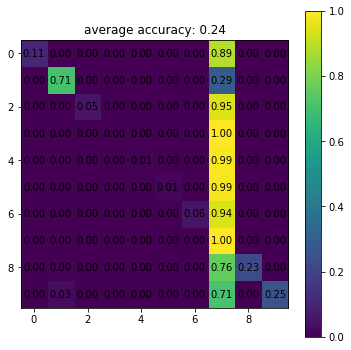

In [7]:
print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = x_test_clean
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [8]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = x_train_clean
x_test_jump = x_test_clean 
y_train_fake = (y_train + np.random.randint(1,10, size=y_train.shape))%10
y_test_fake = (y_test + np.random.randint(1,10, size=y_test.shape))%10
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_target(sess, x_train_clean, x_train_jump, y_train_fake, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_target(sess, x_test_clean, x_test_jump, y_test_fake, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test, update=False, batch_size=batch_size//num_gpu))


(0.39037555, 0.91734)
(0.57049376, 0.84909993)
(4.9216294, 0.8302711774578218)
(5.172378, 0.8375013771069737)
(0.7342574, 0.78036004)
(0.97509444, 0.69920015)
